# Consumption-Savings with Deep Learning methods

In [13]:
import tensorflow as tf
import numpy as np
from math import sqrt
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm         # tqdm is a nice library to visualize ongoing loops
import datetime
# followint lines are used for indicative typing
from typing import Tuple
class Vector: pass

Text(0.5, 1.0, 'test')

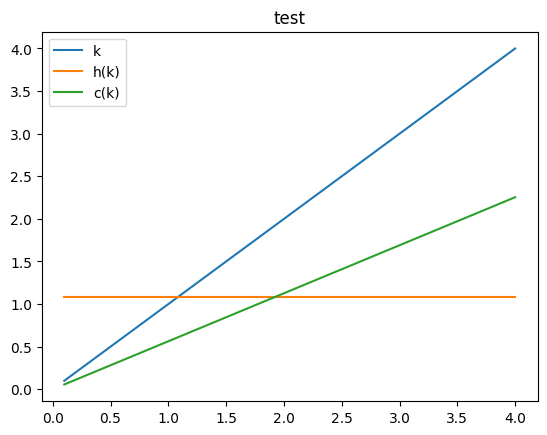

In [14]:
# Model parameters
r = 1.04
γ = 2.0
β = 0.9 
σ = 0.0001
wmin=0.1
wmax=4.0
min_FB = lambda a,b: a+b-tf.sqrt(a**2+b**2)
layers = [
    tf.keras.layers.Dense(32, activation='relu', input_dim=2, bias_initializer='he_uniform'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(2, activation=tf.keras.activations.linear)
]
perceptron = tf.keras.Sequential(layers)

def model(y:Vector,w:Vector)->Tuple[Vector,Vector]:
    y = y/σ/2.0
    w = (w-wmin)/(wmax-wmin)*2.0-1.0
    s = tf.concat([i[:,None] for i in [y,w]],axis=1)
    x = perceptron(s)
    sh = tf.sigmoid(x[:,0])
    h = tf.exp(x[:,1])
    return (sh,h)

wvec = np.linspace(wmin,wmax,100,dtype='float32')
shvec, hvec = model(wvec*0,wvec*0)

plt.plot(wvec, wvec, label = 'k')
plt.plot(wvec, hvec, label='h(k)')
plt.plot(wvec, shvec*wvec, label = 'c(k)')
plt.legend()
plt.title('test')

In [15]:
def residuals(e:Vector,y:Vector,w:Vector):
    n = tf.size(y)
    sh,h=model(y,w)
    c=sh*w
    yp=e
    wp=tf.exp(yp)+(w-c)*r
    shp,hp=model(yp,wp)
    cp = shp*wp
    R1 = β*(cp/c)**(-γ)*r-h
    R2 = min_FB(1-h,1-sh)
    return (R1,R2)

residuals(wvec,wvec,wvec)

(<tf.Tensor: shape=(100,), dtype=float32, numpy=
 array([-1.53765322e+04, -6.23274875e+05, -2.52645880e+07, -1.02403539e+09,
        -4.15101338e+10, -1.68250730e+12, -6.81992446e+13, -2.76453489e+15,
        -1.12046506e+17, -4.54179556e+18, -1.84112536e+20, -7.46332758e+21,
        -3.02497636e+23, -1.22628386e+25, -4.97004907e+26, -2.01451290e+28,
        -8.16693238e+29, -3.31000432e+31, -1.34156413e+33, -5.43776997e+34,
        -2.20449811e+36, -8.93577759e+37,            -inf,            -inf,
                   -inf,            -inf,            -inf,            -inf,
                   -inf,            -inf,            -inf,            -inf,
                   -inf,            -inf,            -inf,            -inf,
                   -inf,            -inf,            -inf,            -inf,
                   -inf,            -inf,            -inf,            -inf,
                   -inf,            -inf,            -inf,            -inf,
                   -inf,            -in

In [16]:
def J(n):
    y = tf.random.normal(shape=(n,),stddev=σ)
    w = tf.random.uniform(shape=(n,),minval=wmin,maxval=wmax)
    e1 = tf.random.normal(shape=(n,),stddev=σ)
    e2 = tf.random.normal(shape=(n,),stddev=σ)
    R1_e1, R2_e1 = residuals(e1, y, w)
    R1_e2, R2_e2 = residuals(e2, y, w)
    R_squared = R1_e1*R1_e2+R2_e1*R2_e2
    return tf.reduce_mean(R_squared)

In [17]:
n = 128
v = J(100)
v.numpy()

0.31687826

In [18]:
θ = perceptron.trainable_variables
print(str(θ)[:1000])

[<tf.Variable 'dense_4/kernel:0' shape=(2, 32) dtype=float32, numpy=
array([[-0.1520639 , -0.34688425, -0.24204741, -0.37981638,  0.24004808,
         0.2502664 ,  0.22724035,  0.29348537, -0.11779699, -0.0739069 ,
         0.15488848,  0.10064039, -0.17095219,  0.2430627 ,  0.39487788,
        -0.30986923,  0.05561414,  0.11973509, -0.08647054,  0.2687687 ,
         0.18591478,  0.16534045, -0.2328416 , -0.27903527, -0.4012964 ,
        -0.12585431, -0.32529664,  0.1316692 ,  0.07381704,  0.36370793,
        -0.40596336, -0.06754911],
       [ 0.03693917, -0.19303346,  0.4122775 , -0.38988233,  0.02790824,
        -0.05386451,  0.29503056,  0.11915728, -0.18089005,  0.29875943,
        -0.14297235,  0.11856589, -0.24304546,  0.28521547,  0.3243616 ,
        -0.25935173,  0.3097938 , -0.15813696,  0.4051074 , -0.0022608 ,
         0.16415861,  0.05094796, -0.3921001 , -0.0494886 ,  0.4153001 ,
         0.03816178, -0.30773813,  0.02922097, -0.40411597, -0.17199071,
         0.10020772,

In [19]:
from tensorflow.keras.optimizers import Adam, SGD
variables = perceptron.trainable_variables
optimizer = Adam()

In [20]:
@tf.function
def training_step():
    
    with tf.GradientTape() as tape:
        xx = J(n)
        
    grads = tape.gradient(xx,θ)
    optimizer.apply_gradients(zip(grads,θ))
    
    return xx

def train_me(K):
    vals=[]
    for k in tqdm(tf.range(K)):
        val=training_step()
        vals.append(val.numpy())
    return vals

results = train_me(5000)

100%|██████████████████████████████████████| 5000/5000 [00:20<00:00, 247.71it/s]


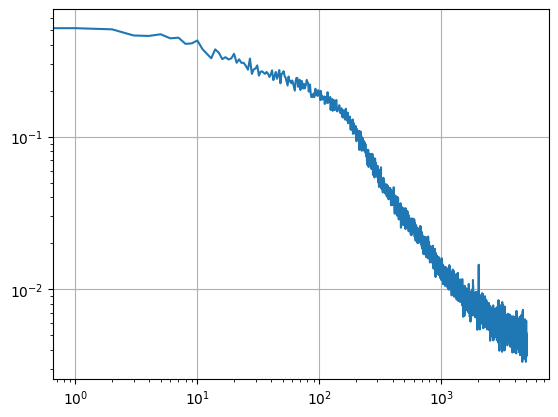

In [21]:
plt.plot(np.sqrt(results))
plt.xscale('log')
plt.yscale('log')
plt.grid()

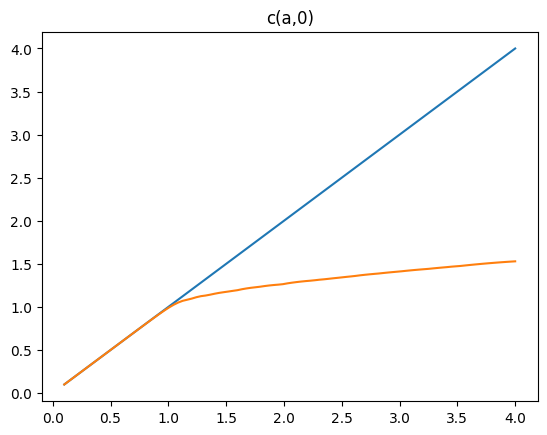

In [22]:
wvec = np.linspace(wmin,wmax,100,dtype='float32')
shvec,hvec = model(wvec*0,wvec)
plt.title('c(a,0)')
plt.plot(wvec,wvec)
plt.plot(wvec,shvec*wvec)
plt.show()

In [23]:
import numpy as np
K = np.linspace(0,3,1000)
K^α+(1-δ)*K

NameError: name 'α' is not defined